In [1]:
import pandas as pd
passenger_train=pd.read_csv('train.csv')
target_col='Survived'
id_col='PassengerId'
target=passenger_train[target_col]
total_num=len(passenger_train)

In [2]:
# drop useless cols
c=passenger_train.count()
drop_cols=c[c*2<len(passenger_train)].index
drop_cols=list(drop_cols)
drop_cols+=[id_col,target_col,'Name','Ticket']
passenger_train.drop(drop_cols,axis=1,inplace=True)

In [3]:
passenger_train.head()

Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  22.0      1      0   7.2500        S
1       1  female  38.0      1      0  71.2833        C
2       3  female  26.0      0      0   7.9250        S
3       1  female  35.0      1      0  53.1000        S
4       3    male  35.0      0      0   8.0500        S

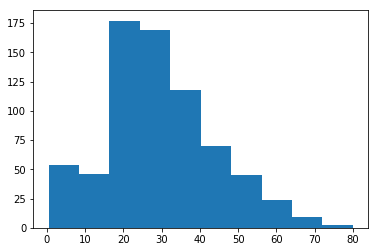

In [4]:
%matplotlib inline
from matplotlib import pyplot

pyplot.hist(passenger_train['Age'].dropna())
pyplot.show()

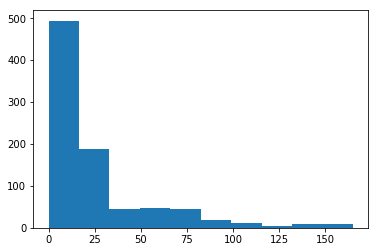

In [5]:
%matplotlib inline
from matplotlib import pyplot

pyplot.hist(passenger_train[passenger_train['Fare']<200]['Fare'].dropna())
pyplot.show()

In [6]:
import sys
sys.path.append('../')
from util import *

In [7]:
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer,LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

summary=passenger_train.describe()
num_imputer=Imputer(strategy='median')

num_pl=Pipeline([
    ('select',DataFrameSelecter(summary.columns)),
    ('fill',Imputer(strategy='median')),
    ('scale',StandardScaler()),
])
num_pl.fit(passenger_train)

cat_cols=list(set(passenger_train.columns)-set(summary.columns))
pls=[Pipeline([
    ('select',DataFrameSelecter2(c)),
    ('drop',NanDropper()),
    ('encode',LabelBinarizer()),
]) for c in cat_cols ]

[pls[i].fit_transform(passenger_train) for i in range(len(cat_cols))]

cat_pls=[(cat_cols[i],Pipeline([
    ('select',DataFrameSelecter3(cat_cols[i])),
    ('encode',pls[i].named_steps['encode']),
])) for i in range(len(cat_cols))]

full_pl=FeatureUnion(transformer_list=[('num',num_pl)]+cat_pls)

prepared_passenger_train_data=full_pl.transform(passenger_train)

# add new cat cols
new_cat_cols=[]
g=lambda i,c: '%s_%s'%(cat_cols[i],c) if len(pls[i].named_steps['encode'].classes_)>2 else None
for i in range(len(cat_cols)):
    for c in pls[i].named_steps['encode'].classes_:
        if len(pls[i].named_steps['encode'].classes_)>2:
            new_cat_cols.append('%s_%s'%(cat_cols[i],c))
        else:
            if cat_cols[i] not in new_cat_cols:
                new_cat_cols.append(cat_cols[i])
new_cat_cols

# delete origin cat cols
cols=list(passenger_train.columns)
[cols.remove(c) for c in cat_cols]

# build new df
prepared_passenger_train=pd.DataFrame(prepared_passenger_train_data,columns=cols+new_cat_cols)
prepared_passenger_train.head()


Pclass       Age     SibSp     Parch      Fare  Sex  Embarked_C  \
0  0.827377 -0.565736  0.432793 -0.473674 -0.502445  1.0         0.0   
1 -1.566107  0.663861  0.432793 -0.473674  0.786845  0.0         1.0   
2  0.827377 -0.258337 -0.474545 -0.473674 -0.488854  0.0         0.0   
3 -1.566107  0.433312  0.432793 -0.473674  0.420730  0.0         0.0   
4  0.827377  0.433312 -0.474545 -0.473674 -0.486337  1.0         0.0   

   Embarked_Q  Embarked_S  
0         0.0         1.0  
1         0.0         0.0  
2         0.0         1.0  
3         0.0         1.0  
4         0.0         1.0

In [8]:
passenger_test=pd.read_csv('test.csv')
test_id=passenger_test[id_col]
drop_cols.remove(target_col)
passenger_test.drop(drop_cols,axis=1,inplace=True)
prepared_passenger_test=full_pl.transform(passenger_test)

## gradient boosting tree

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()

from sklearn.model_selection import cross_val_score

scores=cross_val_score(gbc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()


0.83395386448757236

In [51]:
survived=clf.predict(prepared_passenger_test)
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)

kaggle score:0.78469 rank: 3086

In [10]:
import time
time.time()

1500802274.9865792

### tune params

In [11]:
# from sklearn.model_selection import GridSearchCV
# t1=time.time()
# param_grid={'max_depth':[2,3,5,8],'n_estimators':[50,100,150],'learning_rate':[0.1,0.01]}
# clf=GridSearchCV(GradientBoostingClassifier(),param_grid,scoring='accuracy',cv=10,n_jobs=4)
# clf.fit(prepared_passenger_train,target)
# print(clf.best_score_,clf.best_params_,time.time()-t1)

In [12]:
# survived=clf.predict(prepared_passenger_test)
# df=pd.DataFrame({id_col:test_id,target_col:survived})
# df.to_csv('result.csv',index=False)

kaggle score:0.78469 rank: 3073

## random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()

from sklearn.model_selection import cross_val_score

scores=cross_val_score(rfc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()



0.80823629553966625

not better

In [14]:
from sklearn.svm import SVC
# clf=LinearSVC(C=1,loss='hinge')
svc=SVC(kernel='poly',probability=True)

from sklearn.model_selection import cross_val_score
scores=cross_val_score(svc,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()

0.78467767563273172

## draw validation curve

In [15]:

from sklearn.model_selection import validation_curve

train_scores,test_scores=validation_curve(svc,prepared_passenger_train,target,scoring='roc_auc',param_name='C',param_range=[1],cv=20)
print(train_scores,test_scores)

[[ 0.88278121  0.87794721  0.88518825  0.8776613   0.88091245  0.88291747
   0.87836114  0.87694965  0.87071017  0.87893899  0.87520483  0.87615679
   0.87879163  0.87060713  0.87800177  0.87847333  0.87448571  0.87509579
   0.87060124  0.87118774]] [[ 0.75        0.88293651  0.74789916  0.89915966  0.82773109  0.69327731
   0.90021008  0.93487395  0.90756303  0.82135076  0.81699346  0.8627451
   0.8453159   0.84640523  0.86928105  0.70588235  0.86492375  0.96078431
   0.88453159  0.93464052]]


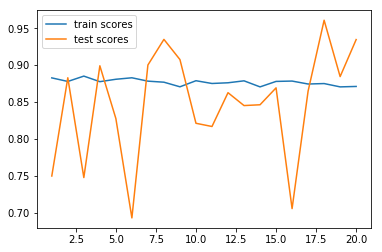

In [16]:
%matplotlib inline
from matplotlib import pyplot

xaxis=[i for i in range(1,len(train_scores[0])+1)]
pyplot.plot(xaxis,train_scores[0],label='train scores')
pyplot.plot(xaxis,test_scores[0],label='test scores')
pyplot.legend()
pyplot.show()

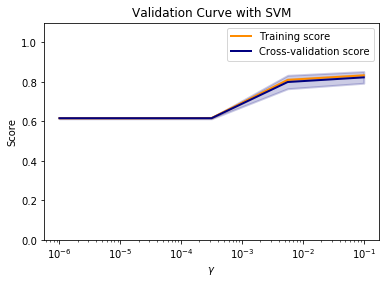

In [17]:
import matplotlib.pyplot as plt
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), prepared_passenger_train, target, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

use ensemble methods

In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

vote=VotingClassifier(estimators=[('gbc',gbc),('rfc',rfc),('svc',svc)],voting='soft')
scores=cross_val_score(vote,prepared_passenger_train,target,scoring='accuracy',cv=10)
scores.mean()

0.82270514130064698

## stacking

In [38]:
from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner

# Creating Ensemble
ensemble = Ensemble([gbc, rfc, svc])
eclf = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))

# from sklearn.model_selection import cross_val_score
# scores=cross_val_score(eclf,prepared_passenger_train,target,scoring='accuracy',cv=10)
eclf.fit(prepared_passenger_train,target)
eclf.score(prepared_passenger_train,target)

0.9135802469135802

In [52]:
survived=eclf.predict(prepared_passenger_test)
survived=[int(s) for s in survived]
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)

not better

In [57]:
# Creating Stacking
layer_1 = Ensemble([gbc, rfc, svc])
layer_2 = Ensemble([sklearn.clone(gbc)])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)
sclf.fit(prepared_passenger_train_data,target)

survived=eclf.predict(prepared_passenger_test)
survived=[int(s) for s in survived]
df=pd.DataFrame({id_col:test_id,target_col:survived})
df.to_csv('result.csv',index=False)